# Optimización de hiperparámetros

Continuaremos utilizando el mismo conjunto de datos previo, e intentaremos construir la mejor red neuronal para resolver la tarea de clasificación.

In [1]:
import numpy as np
import pandas as pd

import seaborn

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from sklearn import metrics

from tqdm.notebook import tqdm

## Cargando los datos del CIFAR10

- El conjunto de datos a utilizar es el **[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)**.
- Es un conjunto estándar para hacer *reconocimiento de imágenes*.
- Buscamos entrenar un clasificador que reconozca que está siendo mostrado en la imagen de un conjunto fijo de categorías posibles.
- El CIFAR10 está compuesto por imágenes a color de 32x32 píxeles representadas como tensores de 32x32x3, donde la tercera dimensión representa el *channel* (i.e. el color en **RGB**). Los valores representan la intensidad de cada color en dicho pixel.
- La salida son 10 clases: avión, auto, pájaro, gato, siervo, perro, sapo, caballo, bote, camión.
- La librería `torchvision` nos facilita obtener el conjunto de datos.

In [2]:
CIFAR_CLASSES = ('plane',
                 'car',
                 'bird',
                 'cat',
                 'deer', 
                 'dog',
                 'frog',
                 'horse',
                 'ship',
                 'truck')

BATCH_SIZE = 128 # For mini-batch gradient descent

# This is to normalize from PILImage to Torch Tensors in range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Definiremos las funciones de entrenamiento y evaluación por separado para ayudar a la legibilidad de los experimentos.

In [3]:
def train(model, optimizer, loss_function, train_loader, EPOCHS, device, use_tqdm=True):
    # Tell the model to set itself to 'train' mode
    model.train()
    for epoch in range(EPOCHS): # Loop over the dataset multiple times
        running_loss = 0.0
        progress_bar = tqdm(train_loader) if use_tqdm else train_loader
        for step, (inputs, labels) in enumerate(progress_bar, 1):
            # Send everything to the device!
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Train
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.view(inputs.shape[0], -1))
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if use_tqdm and step > 0 and step % 50 == 0: # print every 50 mini-batches
                progress_bar.set_description(f'[{epoch + 1}, {step}] loss: {running_loss / step:.4g}')

A la hora de evaluar un modelo sistemáticamente, debemos elegir una métrica principal y, opcionalmente, varias secundarias. En el caso del dataset CIFAR10, en donde las clases están balanceadas adecuadamente, utilizaremos el *accuracy* como métrica principal y el *f1-score* como métrica secundaria.

Además de ello, será útil poder aplicar la función de evaluación sobre distintos subconjuntos del dataset.

In [4]:
def evaluate(model, data_loader, device, prefix='test_', use_tqdm=True):
    # Activate 'eval' mode
    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        progress_bar = tqdm(data_loader) if use_tqdm else data_loader
        for (inputs, labels) in progress_bar:
            # Send everything to the device!
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Evaluate
            outputs = model(inputs.view(inputs.shape[0], -1))
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return {prefix + 'accuracy': metrics.accuracy_score(y_true, y_pred),
            prefix + 'f1': metrics.f1_score(y_true, y_pred, average='macro')}

### Modelo Básico

In [5]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(32 * 32 * 3, 512)
        self.hidden_layer2 = nn.Linear(512, 256)
        self.output_layer = nn.Linear(256, 10)

    def forward(self, x: torch.Tensor):
        x = self.hidden_layer1(x)
        x = F.relu(x)
        x = self.hidden_layer2(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

model = MLP()

In [6]:
print(model)

MLP(
  (hidden_layer1): Linear(in_features=3072, out_features=512, bias=True)
  (hidden_layer2): Linear(in_features=512, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)


# Búsqueda de hiperparámetros

Antes de comenzar a experimentar con distintos tipos de redes, debemos ser organizados a la hora de guardar nuestros resultados. Existen *frameworks* que ayudan con este proceso, pero para concentrarnos mejor en la teoría, utilizaremos un método muy simple guardando hiperparámetros y resultados en un diccionario.

In [7]:
EPOCHS = 5

experiments = []

In [8]:
def run_experiment(model, EPOCHS, train_loader, test_loader, LR=0.001):
    # Check for GPU!
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Loss
    loss_function = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
    # TRAIN!
    train(model, optimizer, loss_function, train_loader, EPOCHS, device)
    # EVALUATE!
    test_results = evaluate(model, test_loader, device)

    experiment = {
        'arquitecture': str(model),
        'loss': str(loss_function),
        'lr': LR,
        'epochs': EPOCHS,
    }
    experiment.update(test_results)
    return experiment

In [9]:
model = MLP() # It's important to re-define the model to avoid keep training an earlier version
experiment = run_experiment(model, EPOCHS, trainloader, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [10]:
experiments.append(experiment)

print(f'Accuracy: {experiment["test_accuracy"]} | F1: {experiment["test_f1"]}')

Accuracy: 0.4293 | F1: 0.4250742488794936


## Tamaño y número de capas

- Las capas de una red nos determinan su **poder de representación**.
- Mientras más neuronas tenga una red, tendrá potencialmente la capacidad de representar problemas con más causas latentes, como por ejemplo el *lenguaje*. Sin embargo, significa que necesitaremos más datos para poder entrenarla.
- Mientras más profunda sea la red, tendrá potencialmente la capacidad de representar problemas donde las relaciones entre las causas latentes son más complicadas, como en el caso de las *imágenes*. Sin embargo, será más difícil de entrenar y propagar los gradientes adecuadamente.

## Funciones de activación

- Una red neuronal con activación lineal no tiene más poder de representación que un algoritmo lineal.
- Para expresar no linearidad en la red neuronal se necesitan funciones no lineales de activación.
- Las funciones de activación más comunes (para utilizar en las capas intermedias) son la *sigmoid*, *tanh*, y *ReLU*. Hoy en día, por sus propiedades, **ReLU** suele ser la más utilizada.
- La función de activación *softmax* suele utilizarse al final de una red de multiples clases, donde tiene como objetivo transformar un vector de *scores* en un vector probabilístico.
    - Si bien solía ser muy común en las primeras versiones de muchos *frameworks* de aprendizaje profundo, con el tiempo se dejó de utilizar y se incluye directamente en la función de costo de manera transparente al usuario.
- En *PyTorch* la mayoría de estas funciones se definen en el módulo [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html).

<img style='margin:auto; width:100%;'
     src='images/1_Activation_Functions.png'
     alt='Funciones de Activación'
     title='Funciones de Activación'
     />

<div style='text-align:right; font-size:0.75em;'>
    Fuente:
    <a href='https://ujjwalkarn.me/2016/08/09/quick-intro-neural-networks/' target='_blank'>
        https://ujjwalkarn.me/2016/08/09/quick-intro-neural-networks/
    </a>
</div>

Veamos que resultado nos da con un modelo con menos capas que el original.

In [11]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(32 * 32 * 3, 256)
        self.output_layer = nn.Linear(256, 10)

    def forward(self, x: torch.Tensor):
        x = self.hidden_layer1(x)
        x = torch.tanh(x)
        x = self.output_layer(x)
        return x

In [12]:
model = SimpleMLP() # It's important to re-define the model to avoid keep training an earlier version
experiment = run_experiment(model, EPOCHS, trainloader, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [13]:
experiments.append(experiment)

print(f'Accuracy: {experiment["test_accuracy"]} | F1: {experiment["test_f1"]}')

Accuracy: 0.413 | F1: 0.40352425766961425


In [14]:
class BigMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(32 * 32 * 3, 256)
        self.hidden_layer2 = nn.Linear(256, 1024)
        self.hidden_layer3 = nn.Linear(1024, 2048)
        self.hidden_layer4 = nn.Linear(2048, 512)
        self.output_layer = nn.Linear(512, 10)

    def forward(self, x: torch.Tensor):
        x = torch.tanh(self.hidden_layer1(x))
        x = torch.tanh(self.hidden_layer2(x))
        x = torch.tanh(self.hidden_layer3(x))
        x = torch.tanh(self.hidden_layer4(x))
        x = self.output_layer(x)
        return x

In [15]:
model = BigMLP() # It's important to re-define the model to avoid keep training an earlier version
experiment = run_experiment(model, EPOCHS, trainloader, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [16]:
experiments.append(experiment)

print(f'Accuracy: {experiment["test_accuracy"]} | F1: {experiment["test_f1"]}')

Accuracy: 0.3951 | F1: 0.3875262827124527


Podemos averiguar la cantidad de parámetros entrenables que tiene cada modelo...

In [17]:
trainable_SimpleMLP = [p.numel() for p in SimpleMLP().parameters() if p.requires_grad]
trainable_MLP = [p.numel() for p in MLP().parameters() if p.requires_grad]
trainable_BigMLP = [p.numel() for p in BigMLP().parameters() if p.requires_grad]

print(f'Trainable parameters in SimpleMLP: {sum(trainable_SimpleMLP)}')
print(f'Trainable parameters in MLP: {sum(trainable_MLP)}')
print(f'Trainable parameters in BigMLP: {sum(trainable_BigMLP)}')

Trainable parameters in SimpleMLP: 789258
Trainable parameters in MLP: 1707274
Trainable parameters in BigMLP: 4203274


## Batch size

Uno de los hiperparámetros más importantes de una red es el tamaño del lote, el cual determina:
* La cantidad de memoria que requiere el modelo para entrenarse.
    - Si ocurre un error **OOM** (*out of memory*), se puede reducir el tamaño del lote.
* El tiempo de entrenamiento.
    - Si se utiliza un GPU, todos los elementos del batch son procesados en paralelo. Adicionalmente, el paso de cómputo del CPU al GPU consume recursos. Por lo tanto, si el batch size es grande, hay menos batches por época, mayor paralelismo y menos cambios de dispositivo.
* La "suavidad" de las actualizaciones de los pesos.
    - La dirección de los gradientes utilizada en cada actualización se calcula en base al promedio de los errores del batch.
    - Si el batch es muy pequeño y el conjunto de datos no es suave, los gradientes pueden ser muy erráticos.

In [18]:
# Ejercicio: explorar distintos tamaños de batch para cada modelo.
SMALL_BATCH_SIZE = 32
BIG_BATCH_SIZE = 512

small_trainloader = torch.utils.data.DataLoader(trainset, batch_size=SMALL_BATCH_SIZE, shuffle=True, num_workers=2)
small_testloader = torch.utils.data.DataLoader(testset, batch_size=SMALL_BATCH_SIZE, shuffle=False, num_workers=2)

big_trainloader = torch.utils.data.DataLoader(trainset, batch_size=BIG_BATCH_SIZE, shuffle=True, num_workers=2)
big_testloader = torch.utils.data.DataLoader(testset, batch_size=BIG_BATCH_SIZE, shuffle=False, num_workers=2)

In [19]:
model = BigMLP() # It's important to re-define the model to avoid keep training an earlier version
experiment = run_experiment(model, EPOCHS, small_trainloader, small_testloader)

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [20]:
experiments.append(experiment)

print(f'Accuracy: {experiment["test_accuracy"]} | F1: {experiment["test_f1"]}')

Accuracy: 0.4515 | F1: 0.44994034067316935


In [21]:
model = BigMLP() # It's important to re-define the model to avoid keep training an earlier version
experiment = run_experiment(model, EPOCHS, big_trainloader, big_testloader)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
experiments.append(experiment)

print(f'Accuracy: {experiment["test_accuracy"]} | F1: {experiment["test_f1"]}')

Accuracy: 0.3233 | F1: 0.28847432243042515


## Tasa de aprendizaje y optimizador

- El *learning rate* determina con qué "velocidad" aprende una red.
    - Si el **lr** es muy bajo, la red aprende muy lento, ya que los pesos se optimizan con deltas muy pequeños.
    - Si el **lr** es muy alto, la red puede provocar que el entrenamiento diverja.
    - Los mejores resultados se consiguen cambiando el valor del **lr** durante el entrenamiento.
- El algoritmo de optimización determina cómo se actualizan los pesos de la red y el learning rate.
    - Si se utiliza el optimizador **SGD** (*stochastic gradient descent*) es recomendable asignar valores al `momentum`, de lo contrario, utilizará el mismo **lr** durante todo el entrenamiento y suele ser muy lento.
    - Los optimizadores más genéricos y que mejor funcionan son **Adam** y **RMSProp**.

Para evaluar qué combinación de *optimizador* **/** *tasa de aprendizaje* es la mejor, tendremos que monitorear el valor de la función de pérdida en cada época.

In [23]:
def run_experiment_OP_and_LR(model,
                             EPOCHS,
                             train_loader,
                             test_loader,
                             optimizer_class=optim.SGD,
                             LR=0.001,
                             use_tqdm=False):
    # Check for GPU!
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Loss
    loss_function = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optimizer_class(model.parameters(), lr=LR)
    # TRAIN!
    train(model, optimizer, loss_function, train_loader, EPOCHS, device, use_tqdm=use_tqdm)
    # EVALUATE!
    test_results = evaluate(model, test_loader, device, use_tqdm=use_tqdm)

    experiment = {
        'arquitecture': str(model),
        'loss': str(loss_function),
        'epochs': EPOCHS,
        'lr': LR,
        'optimizer': str(optimizer_class)
    }
    experiment.update(test_results)
    return experiment

In [24]:
optimizer_experiments = []

# This is going to take some time!
for optimizer_class in [optim.RMSprop, optim.Adagrad, optim.Adam]:
    for lr in [0.0001, 0.001, 0.005, 0.01]:
        print(f'Exploring {optimizer_class}, {lr}')
        experiment = run_experiment_OP_and_LR(MLP(),
                                              EPOCHS,
                                              trainloader,
                                              testloader,
                                              optimizer_class=optimizer_class,
                                              LR=lr)

        optimizer_experiments.append(experiment)

Exploring <class 'torch.optim.rmsprop.RMSprop'>, 0.0001
Exploring <class 'torch.optim.rmsprop.RMSprop'>, 0.001
Exploring <class 'torch.optim.rmsprop.RMSprop'>, 0.005
Exploring <class 'torch.optim.rmsprop.RMSprop'>, 0.01
Exploring <class 'torch.optim.adagrad.Adagrad'>, 0.0001
Exploring <class 'torch.optim.adagrad.Adagrad'>, 0.001
Exploring <class 'torch.optim.adagrad.Adagrad'>, 0.005
Exploring <class 'torch.optim.adagrad.Adagrad'>, 0.01
Exploring <class 'torch.optim.adam.Adam'>, 0.0001
Exploring <class 'torch.optim.adam.Adam'>, 0.001
Exploring <class 'torch.optim.adam.Adam'>, 0.005
Exploring <class 'torch.optim.adam.Adam'>, 0.01


In [25]:
for experiment in optimizer_experiments:
    print(f'OP {experiment["optimizer"]}, LR {experiment["lr"]}',
          '\t|\t',
          f'Acc {experiment["test_accuracy"]}, F1 {experiment["test_f1"]}')

OP <class 'torch.optim.rmsprop.RMSprop'>, LR 0.0001 	|	 Acc 0.518, F1 0.5091263073009676
OP <class 'torch.optim.rmsprop.RMSprop'>, LR 0.001 	|	 Acc 0.5161, F1 0.5144259682438824
OP <class 'torch.optim.rmsprop.RMSprop'>, LR 0.005 	|	 Acc 0.4223, F1 0.4236874850489875
OP <class 'torch.optim.rmsprop.RMSprop'>, LR 0.01 	|	 Acc 0.1536, F1 0.10342196849776739
OP <class 'torch.optim.adagrad.Adagrad'>, LR 0.0001 	|	 Acc 0.3814, F1 0.3699716090095354
OP <class 'torch.optim.adagrad.Adagrad'>, LR 0.001 	|	 Acc 0.4973, F1 0.49395402124341803
OP <class 'torch.optim.adagrad.Adagrad'>, LR 0.005 	|	 Acc 0.5353, F1 0.531192734953973
OP <class 'torch.optim.adagrad.Adagrad'>, LR 0.01 	|	 Acc 0.5375, F1 0.5350684629932208
OP <class 'torch.optim.adam.Adam'>, LR 0.0001 	|	 Acc 0.5208, F1 0.5149419363919383
OP <class 'torch.optim.adam.Adam'>, LR 0.001 	|	 Acc 0.5394, F1 0.5349842430781434
OP <class 'torch.optim.adam.Adam'>, LR 0.005 	|	 Acc 0.4749, F1 0.4574046957124568
OP <class 'torch.optim.adam.Adam'>, LR

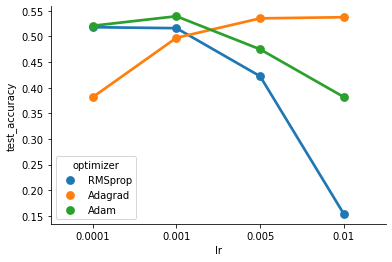

In [26]:
data = pd.DataFrame(data=optimizer_experiments)

data['optimizer'] = data['optimizer'].apply(lambda x: x.split('.')[-1].strip("'>"))

seaborn.pointplot(data=data, x='lr', y='test_accuracy', hue='optimizer')
seaborn.despine()

## Desempeño: overfitting y underfitting

Los modelos de aprendizaje automático tienen dos problemas comunes: puede suceder que sobreajusten a los datos de entrenamiento (*overfitting*) y no generalicen a datos no vistos o, por el contrario, que no tengan la capacidad de aprender el conjunto de entrenamiento (*underfitting*).

* En caso de **overfitting**...
    * Reducir el número de parámetros de la red.
    * Recolectar más datos o datos más diversos.
    * Regularizar la red.

* En caso de **underfitting**...
    * Decrementar la regularización de la red.
    * Cambiar la arquitectura de la red, aumentando el número de parámetros o buscando nuevas combinaciones de capas (recurrencias, convoluciones, etc.).

Para diagnosticar estos problemas es necesario examinar las curvas de aprendizaje del modelo en el conjunto de entrenamiento y en un conjunto de datos no visto (validación).

In [27]:
def train_and_evaluate(model, optimizer, loss_function, train_loader, val_loader, EPOCHS, device, use_tqdm=True):
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader) if use_tqdm else train_loader
        for step, (inputs, labels) in enumerate(progress_bar, 1):
            # Send everything to the device!
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs.view(inputs.shape[0], -1))
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if use_tqdm and step > 0 and step % 50 == 0:
                progress_bar.set_description(f'[{epoch + 1}, {step}] loss: {running_loss / step:.4g}')
        history['train_loss'].append((epoch, running_loss / step))

        # At the end of the epoch, evaluate model on validation!
        model.eval();
        running_loss = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():
            progress_bar = tqdm(val_loader) if use_tqdm else val_loader
            for step, (inputs, labels) in enumerate(progress_bar, 1):
                # Send everything to the device!
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs.view(inputs.shape[0], -1))
                running_loss += loss_function(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        history['val_accuracy'].append(metrics.accuracy_score(y_true, y_pred))
        history['val_loss'].append((epoch, running_loss / step))

    return history

In [28]:
def run_experiment_Over_and_Under(model,
                                  EPOCHS,
                                  train_loader,
                                  test_loader,
                                  optimizer_class=optim.SGD,
                                  LR=0.001,
                                  weight_decay=0.0,
                                  use_tqdm=False):
    # Check for GPU!
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    # Loss
    loss_function = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optimizer_class(model.parameters(), lr=LR, weight_decay=weight_decay)
    # TRAIN and EVALUATE!
    history = train_and_evaluate(model,
                                 optimizer,
                                 loss_function,
                                 train_loader,
                                 test_loader,
                                 EPOCHS,
                                 device,
                                 use_tqdm=use_tqdm)
    test_results = evaluate(model, test_loader, device, use_tqdm=use_tqdm)

    experiment = {
        'arquitecture': str(model),
        'loss': str(loss_function),
        'epochs': EPOCHS,
        'lr': LR,
        'optimizer': str(optimizer_class),
        'weight_decay': weight_decay
    }
    experiment.update(history)
    experiment.update(test_results)
    return experiment

In [29]:
model = MLP() # It's important to re-define the model to avoid keep training an earlier version
experiment = run_experiment_Over_and_Under(model,
                                           15,
                                           trainloader,
                                           testloader,
                                           optimizer_class=optim.Adagrad,
                                           LR=0.01)

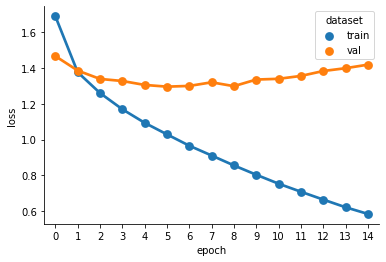

In [30]:
data = []
for epoch, (train_loss, val_loss) in enumerate(zip(experiment['train_loss'], experiment['val_loss'])):
    data.append((epoch, 'train', train_loss[1]))
    data.append((epoch, 'val', val_loss[1]))

data = pd.DataFrame(data=data, columns=['epoch', 'dataset', 'loss'])

seaborn.pointplot(data=data, x='epoch', y='loss', hue='dataset')
seaborn.despine()

## Regularización de la red

### Regularización de los pesos

- La red puede regularizarse penalizando la magnitud de los parámetros.
- Los pesos se regularizan mediante alguna norma:
    - **L1** es la suma del valor absoluto: $ \lambda \sum_{i=1}^{k} |w_i| $
    - **L2** es la suma del valor cuadrado, es la más común: ${\displaystyle \lambda \sum_{i=1}^{k} w_i^2}$
    - **Elastic Net** es una combinación de ambas: ${\displaystyle \lambda_1 \sum_{i=1}^{k} |w_i| + \lambda_2 \sum_{i=1}^{k} w_i^2}$

Para un análisis detallado de la diferencia entre **L1** y **L2** revisar el siguiente [artículo](http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/).

Varios de los algoritmos de optimización implementados en `torch.optim` vienen con una implementación de la norma **L2** para regularización (que suele ser la norma por defecto). Simplemente se debe seleccionar el valor de $\lambda$ que viene representado por el parámetro `weight_decay`.

```python
model = MLP()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
```

Si queremos mayor control (e.g. implementar una versión de **L1** o **Elastic Net**), debemos hacerlo como parte del *training loop*:

```python
l1_lambda = 0.001
model = model.to(device)
model.train()
for inputs, labels in tqdm(trainloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs.view(inputs.shape[0], -1))
    loss = loss_function(outputs, labels)

    l1_reg = torch.tensor(0.).to(device)
    for param in model.parameters():
        l1_reg += torch.norm(param, p=1)
    loss += l1_reg * l1_lambda

    loss.backward()
    optimizer.step()
```

El caso anterior regulariza todos los pesos, i.e. los pesos de las capas y los *bias*. Si sólo queremos regularizar los pesos, se puede utilizar [`nn.Module.named_parameters`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.named_parameters) y filtrar aquellos parámetros que tengan `bias` en el nombre.

```python
l1_reg = torch.tensor(0.)
for param_name, param_weight in model.named_parameters():
    if 'bias' not in param_name:
        l1_reg += torch.norm(param, p=1)
```

In [31]:
WD_experiments = []

for weight_decay in [0, 0.001, 0.01, 0.05, 0.1]:
    print(f'Exploring weight_decay: {weight_decay}')
    model = MLP() # It's important to re-define the model to avoid keep training an earlier version
    WD_experiments.append(run_experiment_Over_and_Under(model,
                                                        10,
                                                        trainloader,
                                                        testloader,
                                                        optimizer_class=optim.Adagrad,
                                                        LR=0.01,
                                                        weight_decay=weight_decay)
                         )

Exploring weight_decay: 0
Exploring weight_decay: 0.001
Exploring weight_decay: 0.01
Exploring weight_decay: 0.05
Exploring weight_decay: 0.1


In [32]:
data = []
for experiment in WD_experiments:
    wd = experiment['weight_decay']
    for epoch, train_loss in experiment['train_loss']:
        data.append((epoch, wd, train_loss, 'train'))
    for epoch, val_loss in experiment['val_loss']:
        data.append((epoch, wd, val_loss, 'val'))

data = pd.DataFrame(data=data, columns=['epoch', 'weight_decay', 'loss', 'dataset'])
data.sample(10)

,epoch,weight_decay,loss,dataset
28,8,0.001,1.055306,train
74,4,0.050,1.768457,val
26,6,0.001,1.131610,train
29,9,0.001,1.017571,train
64,4,0.050,1.767621,train
0,0,0.000,1.665164,train
77,7,0.050,1.737708,val
1,1,0.000,1.376632,train
61,1,0.050,1.828188,train
23,3,0.001,1.278244,train


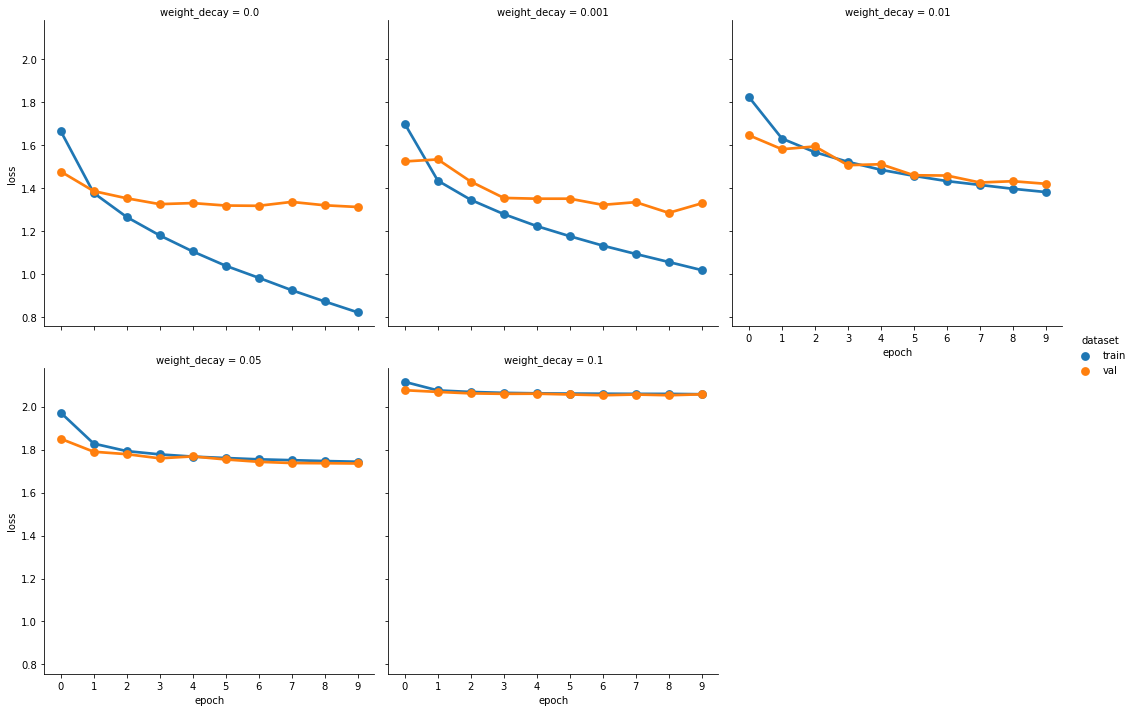

In [33]:
seaborn.catplot(data=data,
                x='epoch',
                y='loss',
                hue='dataset',
                col='weight_decay',
                col_wrap=3,
                kind='point');

### Dropout

- Otra técnica muy usada a la hora de regularizar es el **dropout**.
- Es extremadamente efectivo y simple.
- Es complementario a **L1**/**L2**/**Elastic Net**.
- Durante el entrenamiento se implementa apagando un neurón con alguna probabilidad **_p_** (un hiperparámetro).

<img style='margin:auto; width:75%;'
     src='images/1_Dropout.jpeg'
     alt='Dropout'
     title='Dropout'
     />

<div style='text-align:right; font-size:0.75em;'>
    Fuente: Trabajo de Srivastava
</div>

En *PyTorch*, el *dropout* se implementa agregando capas al modelo. Se utiliza la clase [`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) y se agrega después de la capa que se quiere regularizar.

```python
model = nn.Sequential(
    nn.Linear(32 * 32 * 3, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 10)
)
```

### Batch Normalization

- En general, para acelerar la convergencia de la red, se normalizan los features de entrada, de manera que todos estén en un rango similar.
- Esta idea también puede llevarse a las capas ocultas de la red.
- La idea de la "Normalización por Lotes" (*Batch Normalization*) es reducir el rango en el que se mueven los valores de las neuronas ocultas.
- La manera en que se hace esto es restarle, a cada salida de cada capa oculta, la media del lote (*batch*) de datos de entrenamiento y dividirlo por la desviación estándar (a grandes razgos).
- Como resultado, la red converge más rápido e incluso se genera un efecto de regularización.

### Batch Normalization en PyTorch

- Se aplica agregando capas al modelo.
- Se llaman capas [`BatchNorm*`](https://pytorch.org/docs/stable/nn.html#normalization-layers), donde `*` se reemplaza por las dimensiones de entrada (`1d`, `2d`, `3d`) y se agrega a cada capa que se quiere normalizar.
- El `momentum` es un parámetro que decide cuánta información de los lotes anteriores se tiene en cuenta a la hora de normalizar el lote actual (en el trabajo original de *Batch Normalization* es `0`).

```python
model = nn.Sequential(
    nn.Linear(32 * 32 * 3, 512),
    nn.BatchNorm1d(512, momentum=0.1),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 10)
)
```